This notebook will sort the image files by Well and FOV across time for more efficient parallel processing. 
The sorted images will be saved in a new directory as renamed files.

In [1]:
import pathlib
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile

In [2]:
raw_data_path = pathlib.Path("../../data/raw_data/").resolve(strict=True)
preprocessed_data_path = pathlib.Path("../../data/preprocessed_data/").resolve()
preprocessed_data_path.mkdir(parents=True, exist_ok=True)
# get the list of dirs in the raw_data_path
dirs = [x for x in raw_data_path.iterdir() if x.is_dir()]

In [3]:
files_dict = {}
for dir in dirs:
    files = [x for x in dir.iterdir() if x.is_file()]
    files_dict[dir.name] = files

output_dict = {
    "experiment": [],
    "file_path": [],
    "file": [],
}
# loop through each experiment and get the file paths
for experiment, files in files_dict.items():
    new_data_path = pathlib.Path(preprocessed_data_path / experiment)
    new_data_path.mkdir(parents=True, exist_ok=True)
    for f in files:
        if not f.suffix == ".npz" and f.suffix == ".tif":
            output_dict["experiment"].append(experiment)
            output_dict["file_path"].append(f)
            output_dict["file"].append(f.name)


files_df = pd.DataFrame(output_dict)
# loop through each experiment and group the files
for experiment in files_df["experiment"].unique():
    tmp_df = files_df[files_df["experiment"] == experiment]
    tmp_df["group"] = tmp_df["file"].str.split("_T", expand=True)[0]
    for group in sorted(tmp_df["group"].unique()):
        file_sorting_df = tmp_df[tmp_df["group"] == group]
        new_group_path = pathlib.Path(
            preprocessed_data_path / experiment / group
        ).resolve()
        new_group_path.mkdir(parents=True, exist_ok=True)
        for i, row in file_sorting_df.iterrows():
            file_name = row["file"]
            old_file_path = row["file_path"]
            new_file_path = pathlib.Path(new_group_path / file_name).resolve()
            shutil.copy(old_file_path, new_file_path)

/tmp/ipykernel_464049/3918670240.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df["group"] = tmp_df["file"].str.split("_T", expand=True)[0]


KeyboardInterrupt: 

: 

## Rename the terminal files to match the correct FOV
We have an issue where the terminal timepoint files have a naming mismatch.
The timelapse data was collected with only four FOVs, but the terminal timepoint was collected with six FOVs.
This should not be an issue usually, **unless** FOV 1-4 from the timelapse do not correspond to FOV 1-4 from the terminal timepoint.
Unfortunately, this is the case for this dataset.
To be more specific, the FOVs correspond as follows:
- Timelapse FOV 1 = Terminal FOV 1
- Timelapse FOV 2 = Terminal FOV 2
- Timelapse FOV 3 = Terminal FOV 4
- Timelapse FOV 4 = Terminal FOV 5
- Terminal FOV 3 and FOV 6 are unused
Essentially, this means that half of our timelapse data is mismatched with the terminal timepoint data, thus missing ground truth labels.
To fix this, we will rename the terminal timepoint files to match the correct FOVs.
To properly rename the files, we will use the following mapping:
- Terminal FOV 1 -> Terminal FOV 1 (no change)
- Terminal FOV 2 -> Terminal FOV 2 (no change)
- Terminal FOV 4 -> Terminal FOV 3 (rename)
- Terminal FOV 5 -> Terminal FOV 4 (rename)

If you are reading this, you might be thinking, "Are you sure the FOVs are mismatched? How do you know?"
Great question! We can verify this by visually inspecting the images.
Please see more details in the [verify_fov_mismatch.ipynb](./verify_fov_mismatch.ipynb) notebook.
In this notebook, we will proceed with renaming the files as described above.



In [ ]:
preprocessed_terminal_data_path = pathlib.Path(
    "../../data/preprocessed_data/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP/"
).resolve(strict=True)
well_fov_dirs = [x for x in preprocessed_terminal_data_path.iterdir() if x.is_dir()]
well_fov_dirs.sort()
for well_fov_dir in well_fov_dirs:
    if "F0003" in well_fov_dir.name:
        # delete logic here
        shutil.rmtree(well_fov_dir)
    elif "F0006" in well_fov_dir.name:
        shutil.rmtree(well_fov_dir)

# now that the F0003 and F0006 dirs are deleted, we can rename the FOVs to be consistent with the timelapse data
for well_fov_dir in well_fov_dirs:
    if "F0004" in well_fov_dir.name:
        new_well_fov_dir = well_fov_dir.parent / well_fov_dir.name.replace(
            "F0004", "F0003"
        )
        # print(f"Renaming {well_fov_dir} to {new_well_fov_dir}")
        shutil.move(well_fov_dir, new_well_fov_dir)
        files = [x for x in new_well_fov_dir.iterdir() if x.is_file()]
        files.sort()

        for file in files:
            if "F0004" in file.name:
                new_file = file.parent / file.name.replace("F0004", "F0003")
                shutil.move(file, new_file)
    elif "F0005" in well_fov_dir.name:
        new_well_fov_dir = well_fov_dir.parent / well_fov_dir.name.replace(
            "F0005", "F0004"
        )
        shutil.move(well_fov_dir, new_well_fov_dir)
        files = [x for x in new_well_fov_dir.iterdir() if x.is_file()]
        files.sort()
        for file in files:
            if "F0005" in file.name:
                new_file = file.parent / file.name.replace("F0005", "F0004")
                shutil.move(file, new_file)

## verify that the FOVs are now consistent with the timelapse data

In [5]:
raw_data_timelapse_path = pathlib.Path(
    "../../data/preprocessed_data/20231017ChromaLive_6hr_4ch_MaxIP"
).resolve(strict=True)
raw_data_terminal_path = pathlib.Path(
    "../../data/preprocessed_data/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP"
).resolve(strict=True)
# get the list of dirs in the raw_data_path
timelapse_fovs = [
    x for x in raw_data_timelapse_path.iterdir() if x.is_file() and x.suffix == ".tif"
]
terminal_fovs = [
    x for x in raw_data_terminal_path.iterdir() if x.is_file() and x.suffix == ".tif"
]


timelapse_fov1 = tifffile.imread(
    pathlib.Path(
        f"{raw_data_timelapse_path}/C-02_F0001/C-02_F0001_T0013_Z0001_C01.tif"
    ).resolve(strict=True)
)
timelapse_fov2 = tifffile.imread(
    pathlib.Path(
        f"{raw_data_timelapse_path}/C-02_F0002/C-02_F0002_T0013_Z0001_C01.tif"
    ).resolve(strict=True)
)
timelapse_fov3 = tifffile.imread(
    pathlib.Path(
        f"{raw_data_timelapse_path}/C-02_F0003/C-02_F0003_T0013_Z0001_C01.tif"
    ).resolve(strict=True)
)
timelapse_fov4 = tifffile.imread(
    pathlib.Path(
        f"{raw_data_timelapse_path}/C-02_F0004/C-02_F0004_T0013_Z0001_C01.tif"
    ).resolve(strict=True)
)
terminal_fov1 = tifffile.imread(
    pathlib.Path(
        f"{raw_data_terminal_path}/C-02_F0001/C-02_F0001_T0001_Z0001_C01.tif"
    ).resolve(strict=True)
)
terminal_fov2 = tifffile.imread(
    pathlib.Path(
        f"{raw_data_terminal_path}/C-02_F0002/C-02_F0002_T0001_Z0001_C01.tif"
    ).resolve(strict=True)
)
terminal_fov3 = tifffile.imread(
    pathlib.Path(
        f"{raw_data_terminal_path}/C-02_F0003/C-02_F0003_T0001_Z0001_C01.tif"
    ).resolve(strict=True)
)
terminal_fov4 = tifffile.imread(
    pathlib.Path(
        f"{raw_data_terminal_path}/C-02_F0004/C-02_F0004_T0001_Z0001_C01.tif"
    ).resolve(strict=True)
)
blank_image = np.zeros_like(timelapse_fov1)

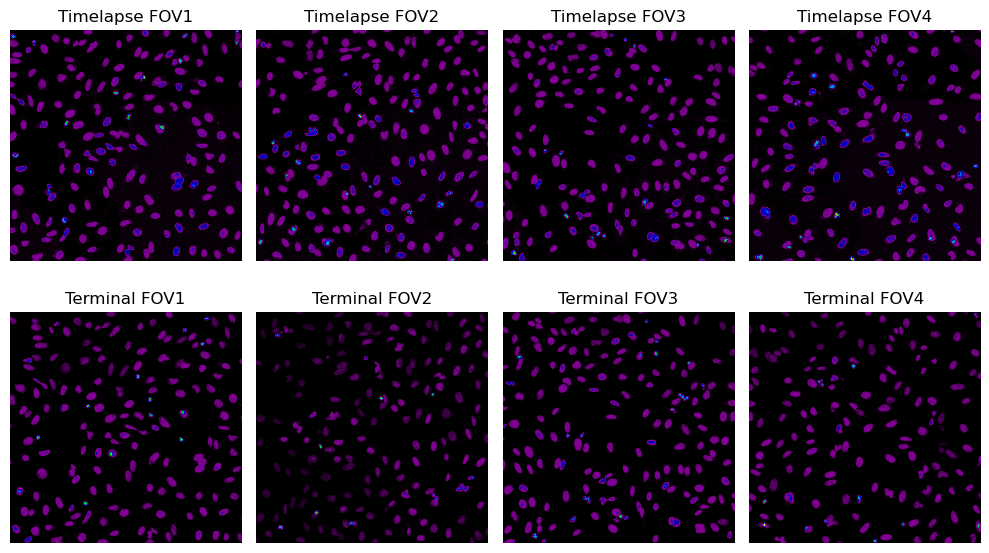

In [6]:
# plot the timelapse image and the terminal image overlaid

plt.figure(figsize=(10, 6))
plt.subplot(2, 4, 1)
plt.imshow(timelapse_fov1, cmap="nipy_spectral")
plt.title("Timelapse FOV1")
plt.axis("off")
plt.subplot(2, 4, 2)
plt.imshow(timelapse_fov2, cmap="nipy_spectral")
plt.title("Timelapse FOV2")
plt.axis("off")
plt.subplot(2, 4, 3)
plt.imshow(timelapse_fov3, cmap="nipy_spectral")
plt.title("Timelapse FOV3")
plt.axis("off")
plt.subplot(2, 4, 4)
plt.imshow(timelapse_fov4, cmap="nipy_spectral")
plt.title("Timelapse FOV4")
plt.axis("off")
plt.subplot(2, 4, 5)
plt.imshow(terminal_fov1, cmap="nipy_spectral")
plt.title("Terminal FOV1")
plt.axis("off")
plt.subplot(2, 4, 6)
plt.imshow(terminal_fov2, cmap="nipy_spectral")
plt.title("Terminal FOV2")
plt.axis("off")
plt.subplot(2, 4, 7)
plt.imshow(terminal_fov3, cmap="nipy_spectral")
plt.title("Terminal FOV3")
plt.axis("off")
plt.subplot(2, 4, 8)
plt.imshow(terminal_fov4, cmap="nipy_spectral")
plt.title("Terminal FOV4")
plt.axis("off")

plt.tight_layout()
plt.show()